# Deep Hedging

This notebook contains one of the projects developed during the *AI for Risk* honour course in Venice (September 14-26, 2025).  

The goal is to learn a hedging strategy for a gap call option using neural networks. This is done for spot price data generated by the Black and Scholes and rough Bergomi models. The hedging strategies are visualized and compared to the B&S deltas. Interesting developments would entail using stock prices from recent developments in generative modeling and analyzing the profit and losses of the strategies.

*Ranieri Dugo, Maotaz Elkady, Rikuki Okamoto*

## Problem formulation

We consider the problem of minimizing the PnL of selling and hedging an option with payoff $f(x)$ and initial price $\pi$,

$$
\arg\underset{H_t\in\mathcal{H}}{\min}\mathbb{E}\left[l\left(f-\pi-\int_0^TH_tdX_t-\gamma\int_0^TX_td\left|H_t\right|\right)\right],
$$

where $X_t$ is the discounted asset price, $H_t$ is the number of shares in the stock (i.e. the hedging strategy), and $\mathcal{H}$ is the class of all predictable processes.

Following Bühler et al. (2018), we simplify the problem by discretizing in time and parametrizing the hedging strategy $H_t$ by a neural networks function of the current asset price, $H_t^\theta:=g_t(X_{t-1};\theta)\in\mathcal{NN}$, parametrized by $\theta$,

$$
\arg\underset{H_t^\theta\in\mathcal{NN}}{\min} \mathbb{E}
\left[
  \left(f-\pi-\sum_{t=0}^{N-1} H^\theta_{(t+1)\Delta} \left(X_{(t+1)\Delta}-X_{t\Delta}\right)-
\gamma\sum_{t=0}^{N-1} X_{t\Delta}\left|H_{(t+1)\Delta}^\theta - H_{t\Delta}^\theta\right|\right)
\right],
$$

where $\Delta=1/N,\ N\in\mathbb{N}$, $H_0^\theta:=0$, and $\gamma$ are proportional transaction costs.


Importing libraries

In [56]:
import numpy as np
import tensorflow as tf
from keras.layers import Input, Dense, Concatenate, Subtract, Multiply, Lambda, Add
from keras.models import Model
from keras import initializers
import scipy.stats as scipy
from scipy.stats import norm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

## The spot price process
We start with the Black and Scholes framework, where the *discounted asset price*, $(X_t)_{t\in{\left[0,T\right]}}$, is given by the dynamics
$$
dX_t=\sigma X_t dW_t,\ \ \ t\in[0,T]
$$
with solution
$$
X_t=X_0\exp{\left(-\frac{\sigma^2}{2} t + \sigma \sqrt{t} Z\right)},
$$
or equivalently,
$$
X_{t+\Delta}=X_t\exp{\left(-\frac{\sigma^2}{2} \Delta + \sigma \sqrt{\Delta} Z\right)},\ \ \ \ Z\sim\mathcal{N}(0,1)
$$

We simulate $\log X_{t+\Delta}$ using the expression above on a grid with $t=0,\Delta, 2\Delta,\dots,N\Delta=1,\ \Delta=\frac{1}{30}$ until $T=N\Delta=1$.

In [66]:
N = 30
S0 = 100
T = 1.0
sigma = 0.2
K = 100
L = 120
dim = 1
n_sim = 10 ** 5
gamma = 0
xtrain = ([S0 * np.ones((n_sim, dim))] +
          [np.random.normal(- sigma ** 2 * T / (2 * N),
                            sigma * np.sqrt(T) / np.sqrt(N), (n_sim, dim))
           for i in range(N)])
ytrain = np.zeros((n_sim, 1 + N))

## The derivative

We want to hedge a *gap call option* with payoff depending on the asset price at maturity, $X_T$, given by

$$
f(X_T)=(X_T-L)\mathbb{1}_{\{X_T>K\}},
$$

where $T=1$, $L=120$, and $K=100$.

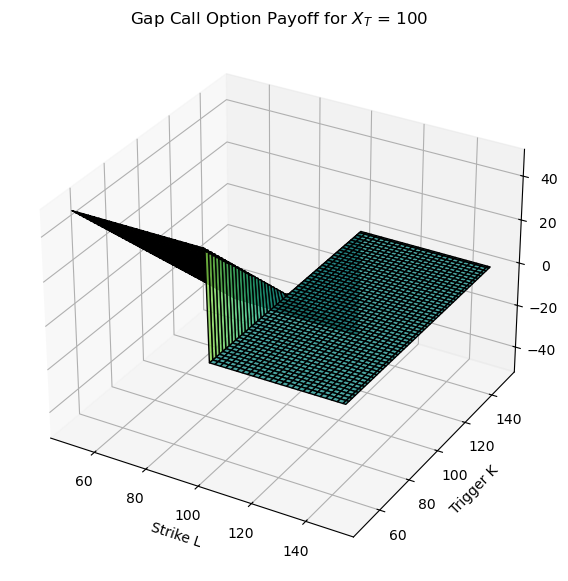

In [58]:
K_lin = np.linspace(50, 150, 100)
L_lin = np.linspace(50, 150, 100)
K_grid, L_grid = np.meshgrid(K_lin, L_lin)
payoff = np.where(S0 > K_grid, S0 - L_grid, 0)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(K_grid, L_grid, payoff, cmap='viridis', edgecolor='k', alpha=0.8)
ax.set_xlabel('Strike L')
ax.set_ylabel('Trigger K')
ax.set_zlabel('Payoff')
ax.set_title('Gap Call Option Payoff for $X_T$ = 100')
plt.show()

## Gap Call Breakdown

It is convenient to break down the payoff of the gap call option in the sum of two terms

$$
\begin{aligned}
f(X_T)=&(X_T-L)\mathbb{1}_{\{X_T>K\}}\\
=&(X_t-K)\mathbb{1}_{\{X_T>K\}}+(K-L)\mathbb{1}_{\{X_T>K\}},
\end{aligned}
$$

the one representing a standard call option with strike $K$ and the second representing $(K-L)$ units of a binary option that pays $1$ when $X_T>K$.

With this trick we can come up with exact formulas for its price,
  
$$
\begin{aligned}
\mathbb{E}^\mathbb{Q}\left[f(X_T)\right]=&\mathbb{E}^\mathbb{Q}\left[(X_t-K)\mathbb{1}_{\{X_T>K\}}\right]+(K-L)\mathbb{E}^\mathbb{Q}\left[\mathbb{1}_{\{X_T>K\}}\right] \\     
\pi:=P_{\text{gap}}\left(X_0,\sigma,L,K,T\right) &= P_{\text{call}}\left(X_0,\sigma,K,T\right) + (K-L) P_{\text{binary}}\left(X_0,\sigma,K,T\right)
\end{aligned}
$$
  
and delta-hedging strategy
  
$$
\frac{\partial{P_{\text{gap}}}}{\partial{X}} = \frac{\partial{P_{\text{call}}}}{\partial{X}} + (K-L) \frac{\partial{P_{\text{binary}}}}{\partial{X}}.
$$

In [67]:
def gap_call_price(S0, K1, K2, sigma, ttm, r = 0, q = 0):
    d1 = (np.log(S0/K2) + (r - q + sigma ** 2 / 2) * ttm) / (sigma * np.sqrt(ttm))
    d2 = d1  - sigma * np.sqrt(ttm)
    price = S0 * np.exp(- q * ttm) * norm.cdf(d1) - K1 * np.exp(- r * ttm) * norm.cdf(d2)
    return price
pi = gap_call_price(S0, L, K, sigma, T)
print(f"The price of the option in the Black and Scholes model is {pi}")

The price of the option in the Black and Scholes model is -1.2378757990536187


## Neural networks hedging strategy

As mentioned, we want to represent
$$
H_t^\theta:=g_t(X_{t-1};\theta),
$$
with a neural network,
$$
g_t:\mathbb{R}\times\Theta\to\mathbb{R},
$$
in which we use *4 hidden layers* of *64 nodes* each and *tanh* activation functions at the hidden layers. The input and output layers are one-dimensional with linear activation.



In [60]:
n_hl = 4
n_nds = 64
layers = []
for j in range(N):
    for i in range(n_hl):
        if i < n_hl - 1:
            nodes = n_nds
            layer = Dense(nodes, activation='tanh', trainable = True,
                      kernel_initializer = initializers.RandomNormal(0,0.1),
                      bias_initializer = initializers.RandomNormal(0,0),
                          name=f"dense_tanh_i{i}_j{j}")
        else:
            nodes = dim
            layer = Dense(nodes, activation='linear', trainable=True,
                          kernel_initializer=initializers.RandomNormal(0,0.1),
                          bias_initializer=initializers.RandomNormal(0,0),
                          name=f"dense_tanh_i{i}_j{j}")
        layers = layers + [layer]

Specify the computational graph in *Tensorflow*

In [61]:
price = Input(shape = (dim, ))
hedge = Lambda(lambda x: tf.zeros_like(x))(price)
inputs = [price]
tmp = []
strat_old = 0
for t in range(N):
    strategy = price
    for j in range(n_hl):
        strategy = layers[j + t * n_hl](strategy)
    strat_old = strategy
    incr = Input(shape = (dim, ))
    logprice = Lambda(lambda x : tf.math.log(x))(price)
    logprice = Add()([logprice, incr])
    pricenew = Lambda(lambda x : tf.math.exp(x))(logprice)
    priceincr = Subtract()([pricenew, price])
    hedgenew = Multiply()([strategy, priceincr])
    hedge = Add()([hedge, hedgenew])
    inputs = inputs + [incr]
    price = pricenew
payoff = Lambda(lambda x: (x - L) * tf.cast(x > K, tf.float32) - pi, output_shape=(1,))(price)
outputs = Subtract()([payoff, hedge])
outputs = Concatenate()([outputs])
model_hedge_strat = Model(inputs = inputs, outputs = outputs)

Train the model over *100 epochs* with *batch size of 1024*.

In [62]:
def custom_loss(y_true, y_pred):
    z = y_pred[:, 0] - y_true[:, 0]
    z = tf.reduce_mean(tf.math.square(z))
    return z

model_hedge_strat.compile(optimizer = 'adam', loss = custom_loss)
model_hedge_strat.fit(x = xtrain, y = ytrain, epochs = 30, verbose = True, batch_size = 1024)

Epoch 1/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 59s 35ms/step - loss: 87.9452
Epoch 2/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 49.1066
Epoch 3/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 44.3935
Epoch 4/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 42.4664
Epoch 5/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 41.9775
Epoch 6/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 40.3017
Epoch 7/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 39.6140
Epoch 8/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 37.0977
Epoch 9/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 33.0601
Epoch 10/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 27.3444
Epoch 11/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 23.9679
Epoch 12/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 21.2666
Epoch 13/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 21.0492
Epoch 14/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 18.5644
Epoch 15/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - lo

## Strategy visualization
We compare the learned hedging trategy, $H_t$, with the optimal one obtained with B&S for values of $X_t\in[70,130]$.

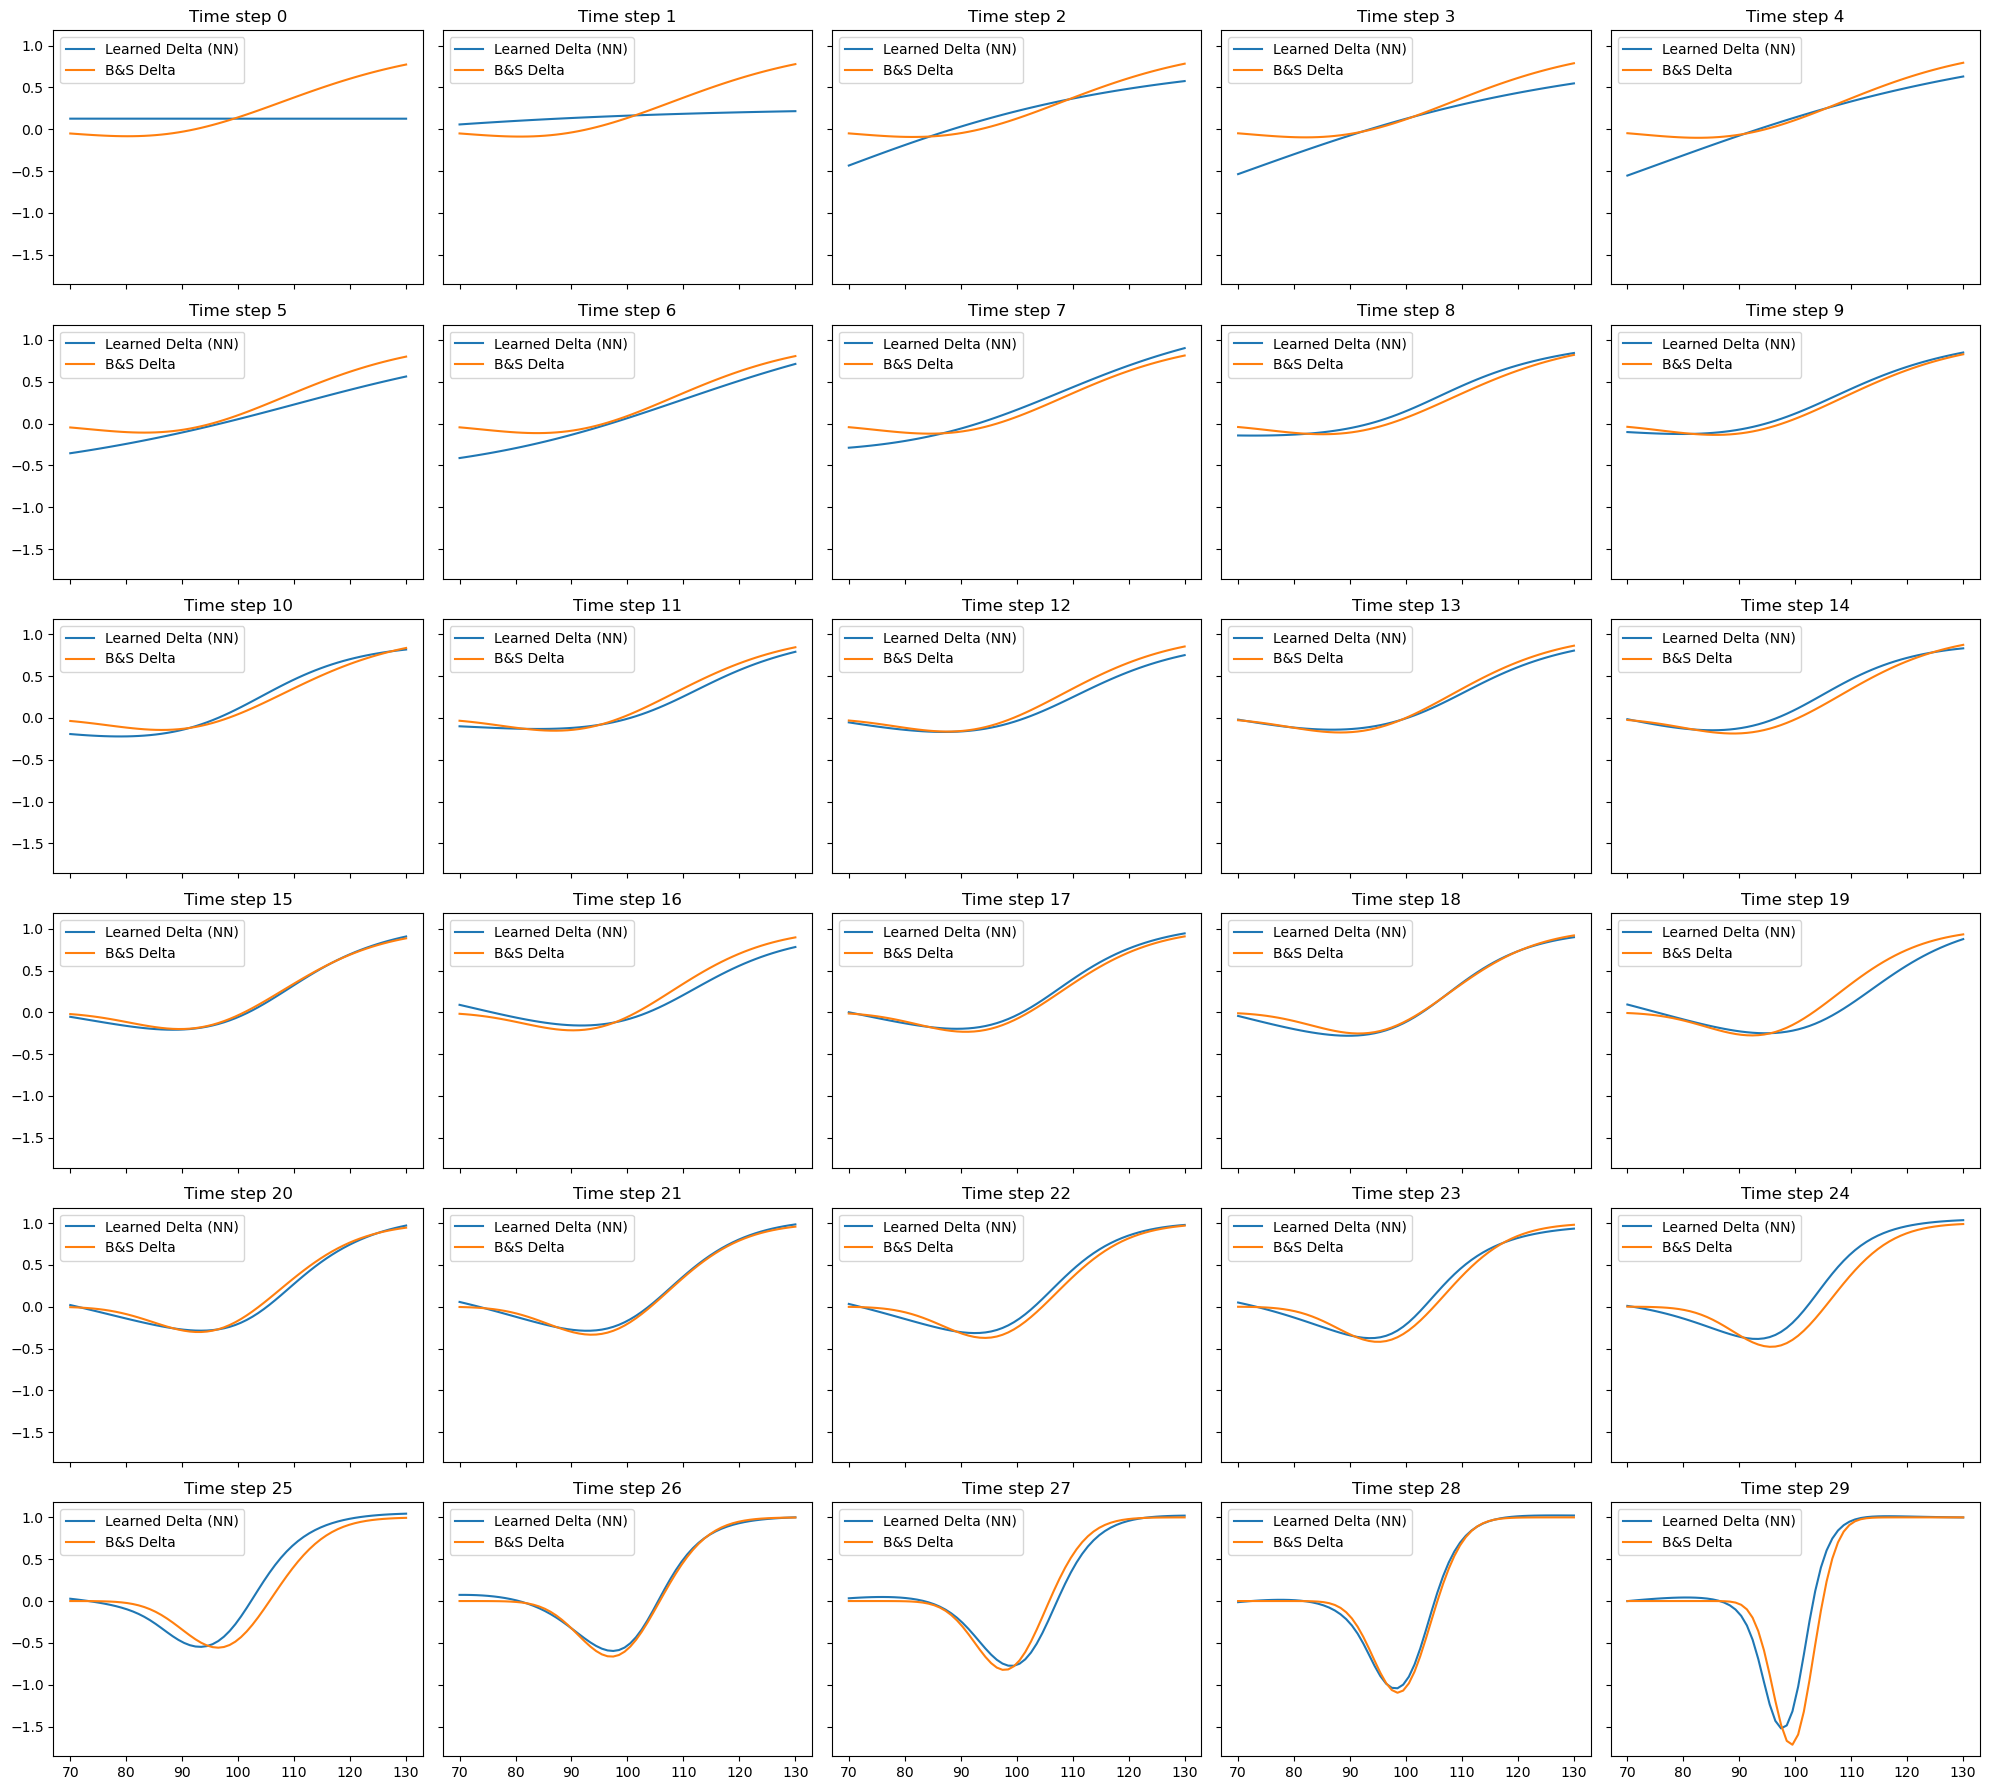

In [63]:
n_test = 60
spot = np.linspace(70, 130, n_test)
cols = 5
rows = (N + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 3 * rows), sharex = True, sharey = True)
axes = axes.flatten()
for t in range(N):
    ttm = (T - t * T / N)
    # exact delta
    d1 = (np.log(spot / K) + 0.5 * sigma ** 2 * ttm) / (sigma * np.sqrt(ttm))
    d2 = d1 - sigma * np.sqrt(ttm)
    delta_call = norm.cdf(d1)
    delta_binary = norm.pdf(d2) / (sigma * spot * np.sqrt(ttm))
    delta_bs = delta_call + (K - L) * delta_binary
    # neural nets hedging evaluation
    delta_nn = np.zeros(n_test)
    for i in range(n_test):
        strategy = np.array([[spot[i]]])
        for j in range(n_hl): 
            strategy = layers[j + t * n_hl](strategy)
        delta_nn[i] = strategy
    ax = axes[t]
    ax.plot(spot, delta_nn, label='Learned Delta (NN)')
    ax.plot(spot, delta_bs, label='B&S Delta')
    ax.set_title(f'Time step {t}')
    ax.legend()
for ax in axes[N : ]:
    ax.axis('off')
plt.tight_layout()
plt.show()

## Transaction costs

What happens when we set $\gamma=1$? 100% proportional transaction costs are clearly too high, but they serve as sanity check because we can expect what happens (no hedge)

Epoch 1/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 68s 31ms/step - loss: 229509.3750
Epoch 2/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 154.5851
Epoch 3/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 102.3290
Epoch 4/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 90.1335
Epoch 5/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 88.1238
Epoch 6/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 86.0894
Epoch 7/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 90.6017
Epoch 8/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 143.5784
Epoch 9/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 3585.5691
Epoch 10/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 39951.4141
Epoch 11/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 169.9469
Epoch 12/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 91.2533
Epoch 13/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 85.5839
Epoch 14/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 84.2060
Epoch 15/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 4

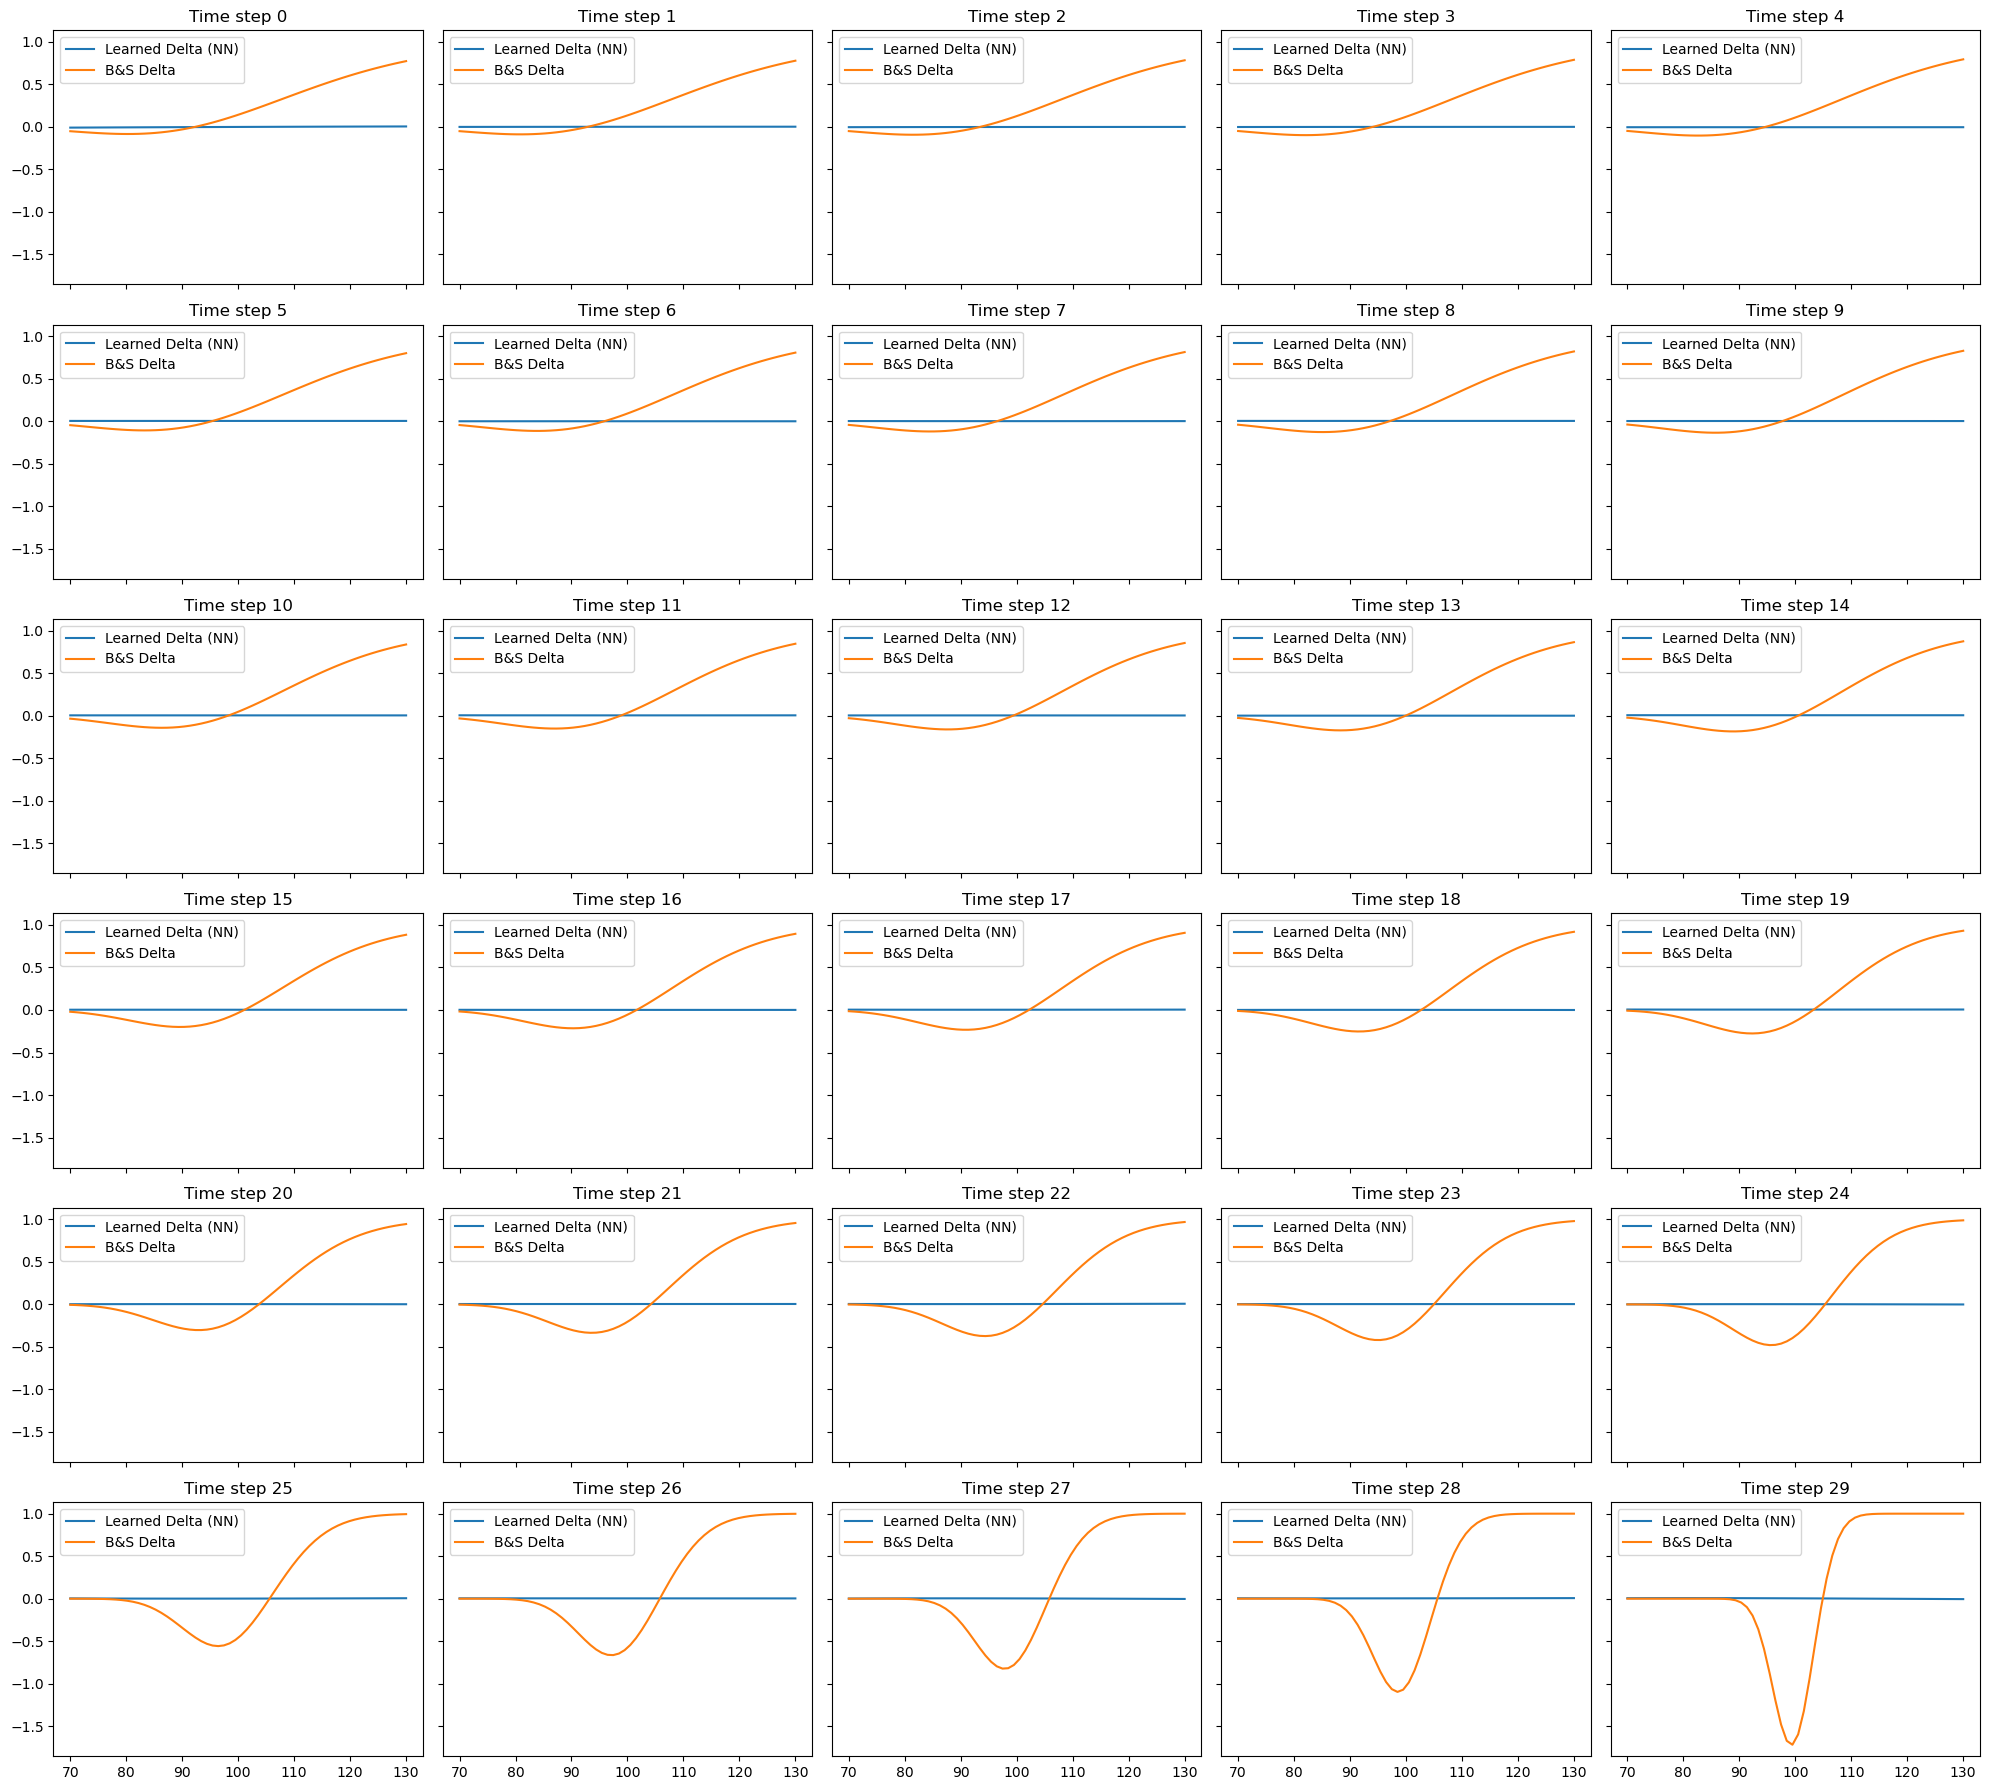

In [64]:
# proportional transaction costs
gamma = 1

# neural nets
n_hl = 4
n_nds = 64
layers = []
for j in range(N):
    for i in range(n_hl):
        if i < n_hl - 1:
            nodes = n_nds
            layer = Dense(nodes, activation='tanh', trainable = True,
                      kernel_initializer = initializers.RandomNormal(0,0.1),
                      bias_initializer = initializers.RandomNormal(0,0),
                          name=f"dense_tanh_i{i}_j{j}")
        else:
            nodes = dim
            layer = Dense(nodes, activation='linear', trainable=True,
                          kernel_initializer=initializers.RandomNormal(0,0.1),
                          bias_initializer=initializers.RandomNormal(0,0),
                          name=f"dense_tanh_i{i}_j{j}")
        layers = layers + [layer]
        
# computational graph specification and training
price = Input(shape = (dim, ))
hedge = Lambda(lambda x: tf.zeros_like(x))(price)
trans_cost = Lambda(lambda x: tf.zeros_like(x))(price)
inputs = [price]
tmp = []
strat_old = 0
for t in range(N):
    strategy = price
    for j in range(n_hl):
        strategy = layers[j + t * n_hl](strategy)
    change_strategy = strategy - strat_old
    strat_old = strategy

    incr = Input(shape = (dim, ))
    logprice = Lambda(lambda x : tf.math.log(x))(price)
    logprice = Add()([logprice, incr])
    pricenew = Lambda(lambda x : tf.math.exp(x))(logprice)
    abs_change_strategy = Lambda(lambda x: tf.abs(x))(change_strategy)
    trans_cost_new = gamma * pricenew * abs_change_strategy
    trans_cost = Add()([trans_cost_new, trans_cost])
    priceincr = Subtract()([pricenew, price])
    hedgenew = Multiply()([strategy, priceincr])
    hedge = Add()([hedge, hedgenew])
    inputs = inputs + [incr]
    price = pricenew
payoff = Lambda(lambda x: (x - L) * tf.cast(x > K, tf.float32) - pi, output_shape=(1,))(price)
outputs = Subtract()([
    Subtract()([payoff, hedge]),
    trans_cost])
outputs = Concatenate()([outputs])
model_hedge_strat = Model(inputs = inputs, outputs = outputs)
model_hedge_strat.compile(optimizer = 'adam', loss = custom_loss)
model_hedge_strat.fit(x = xtrain, y = ytrain, epochs = 30, verbose = True, batch_size = 1024)

# plot
n_test = 60
spot = np.linspace(70, 130, n_test)
cols = 5
rows = (N + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 3 * rows), sharex = True, sharey = True)
axes = axes.flatten()
for t in range(N):
    ttm = (T - t * T / N)
    # exact delta
    d1 = (np.log(spot / K) + 0.5 * sigma ** 2 * ttm) / (sigma * np.sqrt(ttm))
    d2 = d1 - sigma * np.sqrt(ttm)
    delta_call = norm.cdf(d1)
    delta_binary = norm.pdf(d2) / (sigma * spot * np.sqrt(ttm))
    delta_bs = delta_call + (K - L) * delta_binary
    # neural nets hedging evaluation
    delta_nn = np.zeros(n_test)
    for i in range(n_test):
        strategy = np.array([[spot[i]]])
        for j in range(n_hl): 
            strategy = layers[j + t * n_hl](strategy)
        delta_nn[i] = strategy
    ax = axes[t]
    ax.plot(spot, delta_nn, label='Learned Delta (NN)')
    ax.plot(spot, delta_bs, label='B&S Delta')
    ax.set_title(f'Time step {t}')
    ax.legend()
for ax in axes[N : ]:
    ax.axis('off')
plt.tight_layout()
plt.show()

## Rough Bergomi model

We implement the rough Bergomi model (Bayer et. al 2016) as data-generating process for the discounted spot price and solve the same problem as before just by inputting different trajectories $X_t$ and option price $\pi$ (obtained via Monte Carlo). 
The model is specifiedy by

$$
\begin{aligned}
X_t&=X_0\exp{\left(\int_0^t\sigma_s dW_s-\frac{1}{2}\int_0^t\sigma_s^2ds\right)}\\
\sigma^2_t&=\xi_0\exp\left(\eta\int_0^t(t-s)^{H-1/2}dB_s-\frac{\eta^2}{2H}t^{2H}\right)
\end{aligned}
$$

where $S_0=100,\ T=1,\ \eta=1.9,\ H=.07,\ \xi=0.235^2,\ \text{Cor}\left(B_t,W_t\right)=\rho=0.9$.

We simulate the process exactly multiplying the Cholesky factorization of its covariance matrix with a generated matrix of standar Gaussian random variables, as done in Bayer et al. (2018). To obtain the sample you first need to execute *simulation_rBergomi.R*, which will generate the csv file *sim_spot_m1e5_rbergomi.csv*.

The price in the rBergomi model is -3.6444514030303403
Epoch 1/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 52s 57ms/step - loss: 89.4385
Epoch 2/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 78.9478
Epoch 3/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 79.3535
Epoch 4/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 79.3778
Epoch 5/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 76.9054
Epoch 6/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 76.0998
Epoch 7/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 76.5380
Epoch 8/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 74.3185
Epoch 9/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 75.5796
Epoch 10/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 73.8220
Epoch 11/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 72.0376
Epoch 12/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 75.6230
Epoch 13/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 75.5270
Epoch 14/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - l

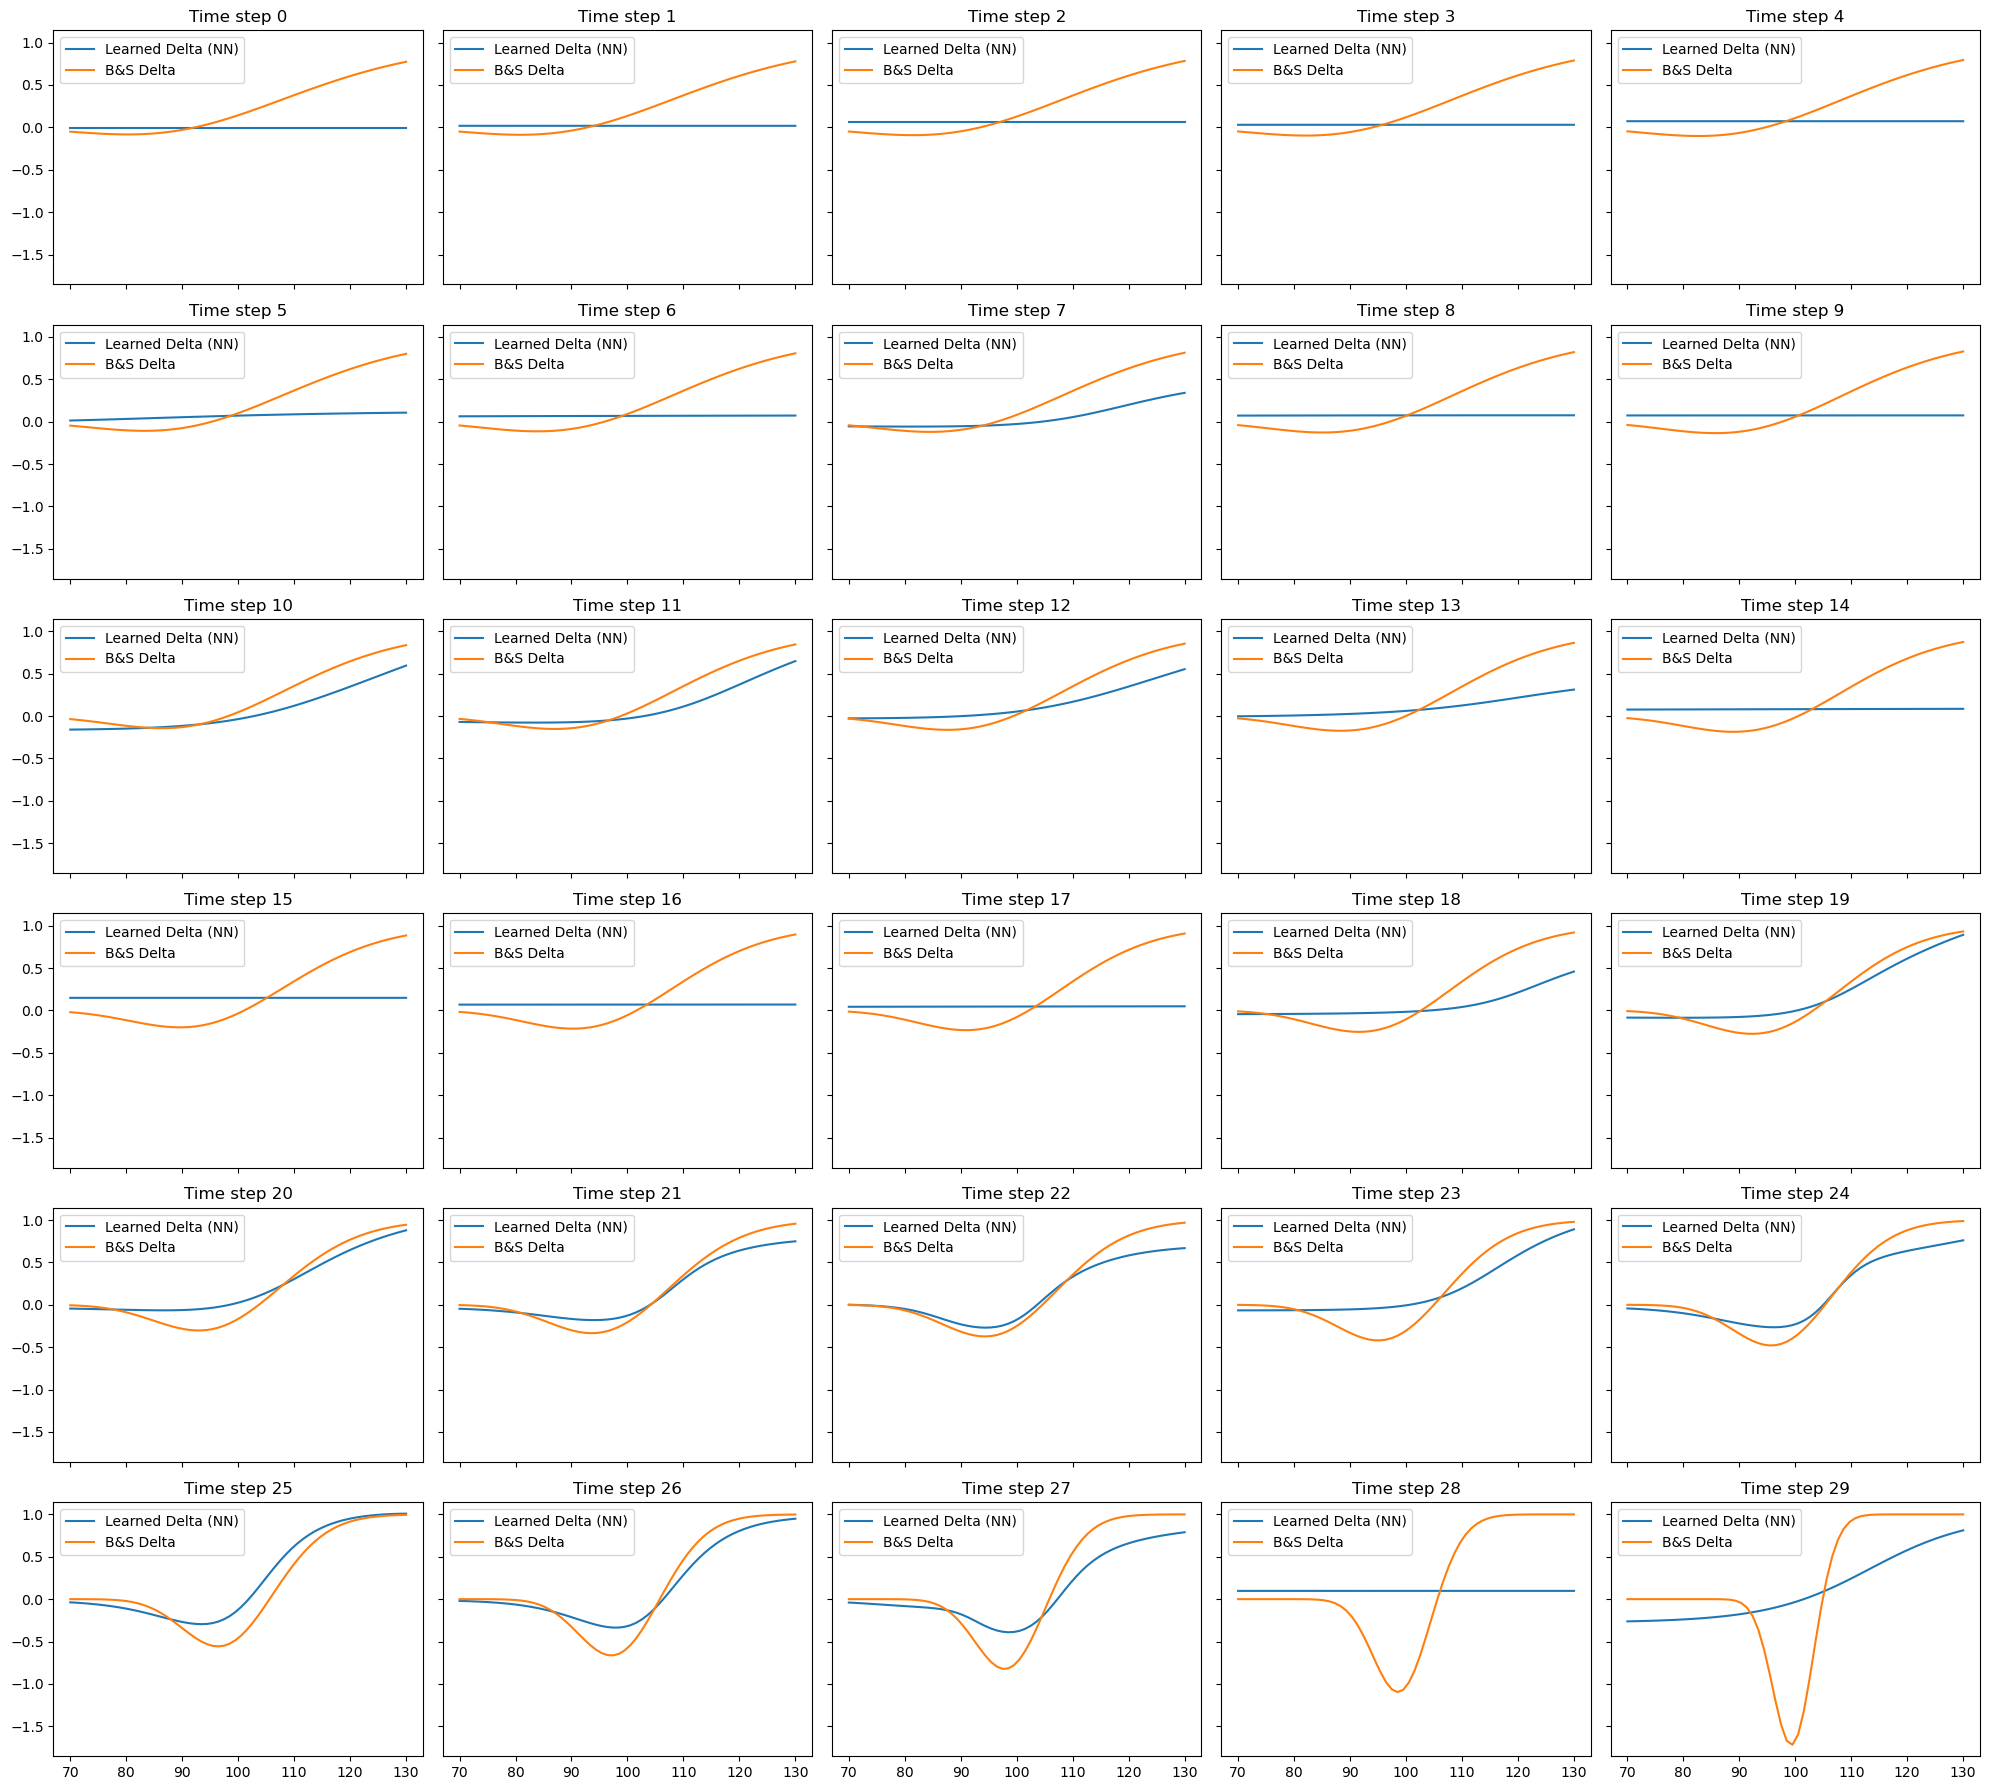

In [65]:
direc = ""
# training set
mspot_rb = S0 * pd.read_csv(direc + "sim_spot_m1e5_rbergomi.csv")
mlogspot_rb = np.log(mspot_rb)
incr = mlogspot_rb.diff().iloc[1 :, :].values.tolist()
incr_reshaped = [np.array(sublist).reshape(-1, 1) for sublist in incr]
xtrain = ([S0 * np.ones((n_sim, dim))] +
          incr_reshaped)
ytrain = np.zeros((n_sim, 1 + N))
pi = np.mean((mspot_rb.iloc[N, : ].values - L) * ((mspot_rb.iloc[N, : ].values - K) > 0).astype(int))
print(f"The price of the option in the rBergomi model is {pi}")

# test set
n_test = 60
s = np.linspace(70, 130, n_test)
mspot_rb = S0 * pd.read_csv(direc + "sim_test_spot_m1e2_rbergomi.csv").iloc[ : , 0 : n_test]
mlogspot_rb = np.log(mspot_rb)
incr = mlogspot_rb.diff().iloc[1 :, :].values.tolist()
incr_reshaped = [np.array(sublist).reshape(-1, 1) for sublist in incr]
xtest = ([S0 * np.ones((n_test, dim))] + incr_reshaped)

# deep hedging
gamma = 0
n_hl = 4
n_nds = 64
layers = []
for j in range(N):
    for i in range(n_hl):
        if i < n_hl - 1:
            nodes = n_nds
            layer = Dense(nodes, activation = 'tanh', trainable = True,
                      kernel_initializer = initializers.RandomNormal(0,0.1),
                      bias_initializer = initializers.RandomNormal(0,0),
                          name=f"dense_tanh_i{i}_j{j}")
        else:
            nodes = dim
            layer = Dense(nodes, activation='linear', trainable=True,
                          kernel_initializer=initializers.RandomNormal(0,0.1),
                          bias_initializer=initializers.RandomNormal(0,0),
                          name=f"dense_tanh_i{i}_j{j}")
        layers = layers + [layer]
price = Input(shape = (dim, ))
hedge = Lambda(lambda x: tf.zeros_like(x))(price)
trans_cost = Lambda(lambda x: tf.zeros_like(x))(price)
inputs = [price]
tmp = []
strat_old = 0
for t in range(N):
    strategy = price
    strategy_eval = foo
    for j in range(n_hl):
        strategy = layers[j + t * n_hl](strategy)
    change_strategy = strategy - strat_old
    strat_old = strategy
    incr = Input(shape = (dim, ))
    logprice = Lambda(lambda x : tf.math.log(x))(price)
    logprice = Add()([logprice, incr])
    pricenew = Lambda(lambda x : tf.math.exp(x))(logprice)
    abs_change_strategy = Lambda(lambda x: tf.abs(x))(change_strategy)
    trans_cost_new = gamma * pricenew * abs_change_strategy
    trans_cost = Add()([trans_cost_new, trans_cost])
    priceincr = Subtract()([pricenew, price])
    hedgenew = Multiply()([strategy, priceincr])
    hedge = Add()([hedge, hedgenew])
    inputs = inputs + [incr]
    price = pricenew
payoff = Lambda(lambda x: (x - L) * tf.cast(x > K, tf.float32) - pi, output_shape=(1,))(price)
outputs = Subtract()([
    Subtract()([payoff, hedge]),
    trans_cost])
outputs = Concatenate()([outputs])
model_hedge_strat = Model(inputs = inputs, outputs = outputs)
model_hedge_strat.compile(optimizer = 'adam', loss = custom_loss)
model_hedge_strat.fit(x = xtrain, y = ytrain, epochs = 100, verbose = True, batch_size = 1024)
# plot
n_test = 60
spot = np.linspace(70, 130, n_test)
cols = 5
rows = (N + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 3 * rows), sharex = True, sharey = True)
axes = axes.flatten()
for t in range(N):
    ttm = (T - t * T / N)
    # exact delta
    d1 = (np.log(spot / K) + 0.5 * sigma ** 2 * ttm) / (sigma * np.sqrt(ttm))
    d2 = d1 - sigma * np.sqrt(ttm)
    delta_call = norm.cdf(d1)
    delta_binary = norm.pdf(d2) / (sigma * spot * np.sqrt(ttm))
    delta_bs = delta_call + (K - L) * delta_binary
    # neural nets hedging evaluation
    delta_nn = np.zeros(n_test)
    for i in range(n_test):
        strategy = np.array([[spot[i]]])
        for j in range(n_hl): 
            strategy = layers[j + t * n_hl](strategy)
        delta_nn[i] = strategy
    ax = axes[t]
    ax.plot(spot, delta_nn, label='Learned Delta (NN)')
    ax.plot(spot, delta_bs, label='B&S Delta')
    ax.set_title(f'Time step {t}')
    ax.legend()
for ax in axes[N : ]:
    ax.axis('off')
plt.tight_layout()
plt.show()